In [1]:
!pip install emcee

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import emcee

In [3]:
hdul1 = fits.open("C:/Users/Sara Trevisan/Downloads/SPT-CL_J2344-4243/SPT-CL_J2344-4243_band3_combined.dat.im.image.fits")
hdul2 = fits.open("C:/Users/Sara Trevisan/Downloads/SPT-CL_J2344-4243/SPT-CL_J2344-4243_band3_combined.jac.im.image.fits")

In [4]:
num_hdus = len(hdul1)
print(f"Numero di HDU nel file FITS: {num_hdus}")

data = hdul1[0].data
noise = hdul2[0].data

print(f"Dimensioni dei dati: {data.shape}")
print(f"Tipo di dati: {data.dtype}")
print(f"Dimensioni dei dati 2: {noise.shape}")
print(f"Tipo di dati 2: {noise.dtype}")

Numero di HDU nel file FITS: 1
Dimensioni dei dati: (2048, 2048)
Tipo di dati: >f4
Dimensioni dei dati 2: (2048, 2048)
Tipo di dati 2: >f4


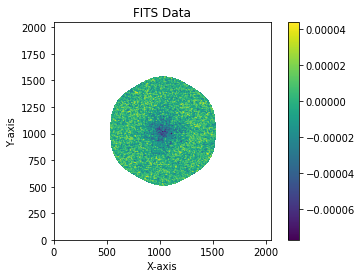

In [5]:
plt.imshow(data, cmap='viridis', origin='lower')  
plt.colorbar()
plt.title('FITS Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


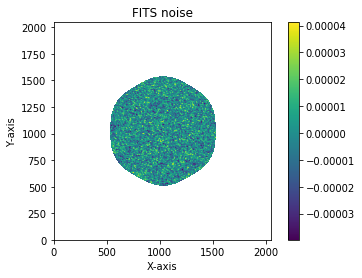

In [6]:
plt.imshow(noise, cmap='viridis', origin='lower')
plt.colorbar()
plt.title('FITS noise')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [7]:
#cerco gli estremi per le coordinate x e y 
valid_pixel_coordinates = np.argwhere(~np.isnan(data))

x_coordinates = valid_pixel_coordinates[:, 1]
y_coordinates = valid_pixel_coordinates[:, 0]


min_x = np.min(x_coordinates)
max_x = np.max(x_coordinates)
min_y = np.min(y_coordinates)
max_y = np.max(y_coordinates)

print("Minimum X (with valid data):", min_x)
print("Maximum X (with valid data):", max_x)
print("Minimum Y (with valid data):", min_y)
print("Maximum Y (with valid data):", max_y)

Minimum X (with valid data): 528
Maximum X (with valid data): 1520
Minimum Y (with valid data): 510
Maximum Y (with valid data): 1538


In [8]:
x = np.arange(data.shape[1])
y = np.arange(data.shape[0]) 

fixed_beta = 0.8  

# guess iniziale 
initial_guess = [1018, 1033, -0.00004, 50]

In [9]:
# maschero i nan value nelle immagini

nan_mask = np.isnan(data)
nan_flag = np.zeros_like(data, dtype=bool)
nan_flag[nan_mask] = True

data_masked = np.ma.masked_array(data, mask=nan_flag)


nan_mask2 = np.isnan(noise)
nan_flag2 = np.zeros_like(noise, dtype=bool)
nan_flag2[nan_mask2] = True

noise_masked = np.ma.masked_array(noise, mask=nan_flag2)


In [10]:
#voglio aggiungere una costante ai dati in modo che non siano vicini allo zero

#constant_value = 1.0

#data_masked[np.isfinite(data_masked)] += constant_value
#noise_masked[np.isfinite(noise_masked)] += constant_value

In [11]:
# definizione del modello 
def beta_model(params, x, y):
    x0, y0, n0, rc = params
    beta = fixed_beta 
    r_squared = (x - x0)**2 + (y - y0)**2
    model = n0 * (1 + r_squared / rc**2)**(-3 * beta / 2)
    return model

In [12]:

def log_prior(params):
    x0, y0, n0, rc = params
    # print("log_prior params:", params)
    # Define your priors here, e.g., uniform priors
    if min_x < x0 < max_x and min_y < y0 < max_y and -1.0 < n0  and 0 < rc < 200:
        return 0.0  
    return -np.inf 

In [13]:
# def log_likelihood(params, x, y, data1, noise_estimate):
#     model = beta_model(params, x, y)
#     residual = data1 - model
#     noise_estimate += 1e-10
#     logl = np.sum(np.log(1. / np.sqrt(2 * np.pi * noise_estimate**2)) - (residual**2) / (2. * noise_estimate**2))
#     print("logl:", logl)
#     return logl
def log_likelihood(params, x, y, data, noise):
    model = beta_model(params, x, y)
    residual = data - model
    logl = np.sum(-0.5 * np.log(2 * np.pi * noise**2) - 0.5 * (residual**2) / noise**2)
    # print("logl:", logl)
    return logl

In [14]:
def log_posterior(params, x, y, data, noise):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(params, x, y, data, noise)

    # print("logl:", logl)
    # print("lp:", lp)

    logpos = logl + lp
    return logpos # , lp, logl


In [15]:
# Definisco il numero di parametri e di walkers 
nwalkers, ndim = 16, 4

#pos = [initial_guess] + 1e-6 * np.random.randn(nwalkers, ndim)
pos = [initial_guess] + [1, 1, 1e-6, 1e-1] * np.random.randn(nwalkers, ndim)

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, data_masked, noise_masked))

In [17]:
# Run the MCMC sampler
n_steps = 500
sampler.run_mcmc(pos, n_steps, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [1:11:56<00:00,  9.66s/it]


State([[ 1.02007288e+03  1.01769146e+03 -2.69619839e-05  5.26733796e+00]
 [ 1.01995437e+03  1.01762408e+03 -2.71734697e-05  5.32430775e+00]
 [ 1.01993965e+03  1.01749177e+03 -2.79234149e-05  5.26733786e+00]
 [ 1.01992952e+03  1.01763418e+03 -2.71541861e-05  5.32397170e+00]
 [ 1.01990175e+03  1.01768114e+03 -2.68759451e-05  5.36072244e+00]
 [ 1.01999544e+03  1.01767419e+03 -2.69638569e-05  5.31683026e+00]
 [ 1.01996243e+03  1.01766596e+03 -2.69666592e-05  5.32121091e+00]
 [ 1.01988048e+03  1.01747641e+03 -2.80059436e-05  5.28706750e+00]
 [ 1.01986297e+03  1.01766351e+03 -2.70669505e-05  5.28556456e+00]
 [ 1.01988721e+03  1.01767047e+03 -2.68830977e-05  5.36137942e+00]
 [ 1.02005914e+03  1.01765868e+03 -2.71447295e-05  5.27746534e+00]
 [ 1.01995159e+03  1.01767069e+03 -2.69886287e-05  5.30413104e+00]
 [ 1.01989992e+03  1.01767939e+03 -2.68371843e-05  5.36837307e+00]
 [ 1.01995250e+03  1.01765510e+03 -2.70231946e-05  5.33592592e+00]
 [ 1.01986221e+03  1.01766633e+03 -2.68947331e-05  5.386

(500, 16, 4)


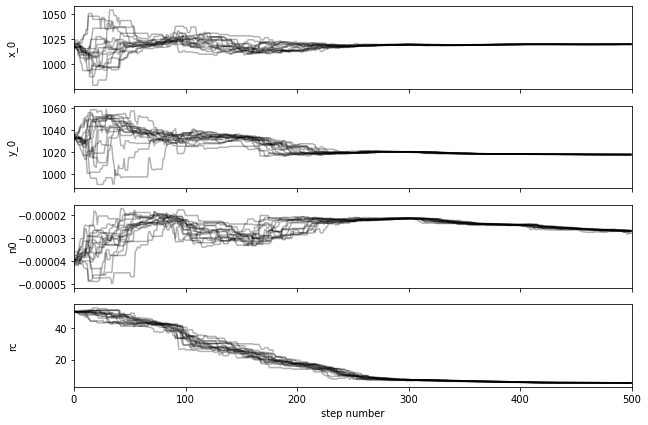

In [18]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["x_0", "y_0", "n0", "rc"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [23.90973895 62.00773462 38.55428204 68.43385236]

In [ ]:
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_blob = sampler.get_blobs(flat=True,discard=100)

print(flat_samples.shape, flat_blob.shape)

Max_likelihood=np.argmax(flat_blob[:,1])
print(flat_samples[Max_likelihood,:])

In [ ]:
import corner
fig = corner.corner(flat_samples, labels=labels)

In [ ]:
import pygtc
GTC = pygtc.plotGTC(chains=flat_samples,paramNames=labels,figureSize=7,holdRC=True,
                    customLabelFont={'size':14},customTickFont={'size':14}, truths=flat_samples[Max_likelihood,:])